In [5]:
import pyaudio
import wave
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

verschuiving = 100  # Kalibratiewaarde
waarde_ref = 32767  # Referentie-amplitude voor dB-conversie

def omzetting(x):
    """Converteert amplitude naar decibel."""
    return (20 * np.log10(x / waarde_ref)) + verschuiving

# Audioconfiguratie
Chunk = 1024  # Aantal frames per buffer (verkleint geheugenbelasting)
Format = pyaudio.paInt16  # 16-bit audioformaat (standaard voor veel toepassingen)
Rate = 44100  # Samplefrequentie in Hz (CD-kwaliteit)
seconds = 5  # Totale opnameduur in seconden
output_file = "test.wav"  # Naam van het uitvoerbestand
Channels = 1  # Mono-opname (voor eenvoudiger verwerking)

# Controleer of het bestand al bestaat en waarschuw de gebruiker
if os.path.exists(output_file):
    print(f"⚠️ Waarschuwing: {output_file} bestaat al. Het zal worden overschreven.")

# Initialiseer PyAudio en start opname
p = pyaudio.PyAudio()
stream = p.open(format=Format, channels=Channels, rate=Rate, input=True, frames_per_buffer=Chunk)

print("🎤 Start opname...")
frames = []  # Opslag voor audioblokken
clipping_detected = False  # Vlag voor detectie van oversturing

# Lees de audioblokken en sla ze op
for _ in range(int(Rate / Chunk * seconds)):
    data = stream.read(Chunk)
    frames.append(data)

    # Controleer op clipping (oversturing)
    audio_array = np.frombuffer(data, dtype=np.int16)
    if np.any(audio_array >= 32767) or np.any(audio_array <= -32768):
        clipping_detected = True
    
print("🛑 Opname gestopt.")
stream.stop_stream()
stream.close()
p.terminate()

# Opslaan als WAV-bestand
with wave.open(output_file, 'wb') as wf:
    wf.setnchannels(Channels)
    wf.setsampwidth(p.get_sample_size(Format))
    wf.setframerate(Rate)
    wf.writeframes(b''.join(frames))

# Geef feedback over mogelijke vervorming
if clipping_detected:
    print("⚠️ Waarschuwing: Clipping gedetecteerd! Het opgenomen geluid is mogelijk vervormd.")
else:
    print("✅ Geen clipping gedetecteerd.")          


⚠️ Waarschuwing: test.wav bestaat al. Het zal worden overschreven.
🎤 Start opname...
🛑 Opname gestopt.
✅ Geen clipping gedetecteerd.


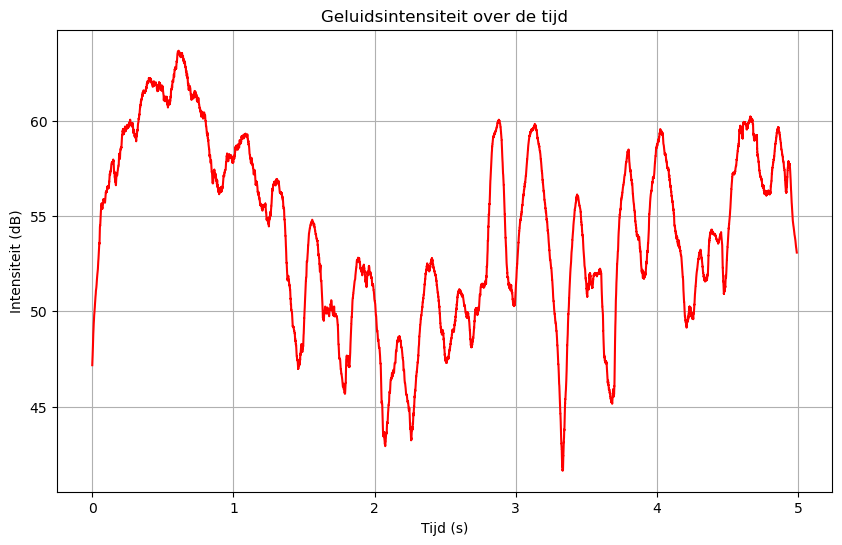

In [7]:
# Inlezen van het .wav-bestand
file_path = output_file
sampling_rate, audio_data = wavfile.read(file_path)

# Tijd-array maken
duration = len(audio_data) / sampling_rate
time = np.linspace(0., duration, len(audio_data))

tijdsinterval = 0.1

# Bepaal de grootte van het tijdsinterval bij het voortschrijdend gemiddelde
window_size = int(tijdsinterval * sampling_rate)  # Aantal samples in het tijdsinterval

# Bereken het voortschrijdend gemiddelde van de absolute waarde van de amplitude
rolling_avg = np.convolve(np.abs(audio_data), np.ones(window_size) / window_size, mode='same')

# Converteer naar decibelwaarden
uit = omzetting(np.abs(rolling_avg))

plt.figure(figsize=(10, 6))
plt.plot(time, uit, color='red')
plt.title('Geluidsintensiteit over de tijd')
plt.xlabel('Tijd (s)')
plt.ylabel('Intensiteit (dB)')
plt.grid()
plt.show()


Piek geluidsniveau: 87.42 dB op 1.19 seconden
Geluidsniveau 30 dB lager (57.42 dB) bereikt op 1.21 seconden
Tijdverschil: 0.02 seconden
Verdubbeld tijdsverschil: 0.04 seconden


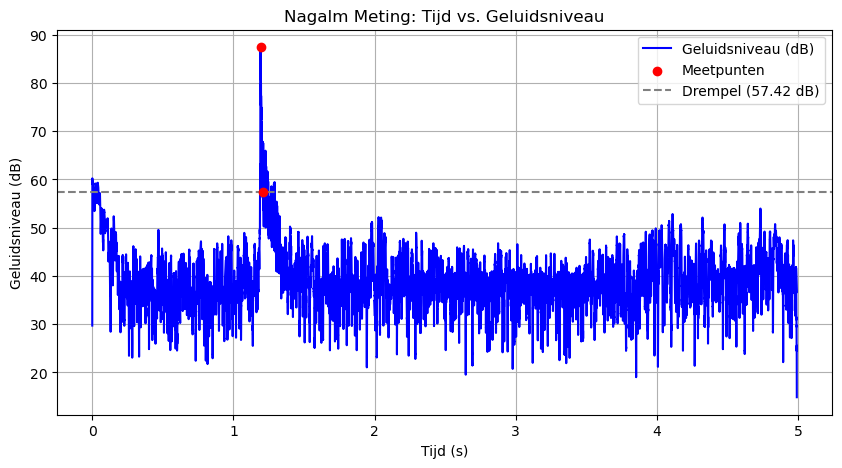

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.signal import medfilt

# Kalibratiewaarde in dB (aanpasbaar)
kalibratie_db = 100  # Pas deze waarde aan indien nodig

# WAV-bestand inlezen
sample_rate, data = wav.read("test.wav")

# Als de audio stereo is, neem dan alleen één kanaal
if len(data.shape) > 1:
    data = data[:, 0]  # Neem alleen het eerste kanaal

# Normaliseren en omzetten naar dB
data = data / np.max(np.abs(data))  # Normaliseer naar -1 tot 1
db = 20 * np.log10(np.abs(data) + 1e-6) + kalibratie_db  # Zet om naar dB en voeg kalibratie toe

# Maak een tijdsvector
tijd = np.linspace(0, len(data) / sample_rate, len(data))

# Stap 1: Pas een klein median filter toe om spikes te verminderen
db_smooth = medfilt(db, kernel_size=5)  # Klein kernel voor minimale verschuiving

# Stap 2: Pas een lopend gemiddelde toe voor extra smoothing
def moving_average(x, window_size):
    return np.convolve(x, np.ones(window_size) / window_size, mode='same')

db_smooth = moving_average(db_smooth, 50)  # Pas een gemiddeld filter toe

# Zoek de piek in dB
max_db = np.max(db_smooth)
t_piek = tijd[np.argmax(db_smooth)]

# Bepaal drempelwaarde (30 dB lager dan piek)
drempel_db = max_db - 30

# Zoek het eerste punt na de piek waar de drempel wordt bereikt
idx_lager = np.argmax((tijd > t_piek) & (db_smooth <= drempel_db))

# Interpolatie om exacte drempelpunt te bepalen
t1, t2 = tijd[idx_lager - 1], tijd[idx_lager]
db1, db2 = db_smooth[idx_lager - 1], db_smooth[idx_lager]
t_drempel = t1 + (t2 - t1) * (drempel_db - db1) / (db2 - db1)

# Bereken tijdsverschil
tijdsverschil = t_drempel - t_piek

# Verdubbel het tijdsverschil
tijdsverschil_x2 = tijdsverschil * 2

# Resultaten printen
print(f"Piek geluidsniveau: {max_db:.2f} dB op {t_piek:.2f} seconden")
print(f"Geluidsniveau 30 dB lager ({drempel_db:.2f} dB) bereikt op {t_drempel:.2f} seconden")
print(f"Tijdverschil: {tijdsverschil:.2f} seconden")
print(f"Verdubbeld tijdsverschil: {tijdsverschil_x2:.2f} seconden")

# Plotten van het resultaat
plt.figure(figsize=(10, 5))
plt.plot(tijd, db_smooth, label="Geluidsniveau (dB)", color="b")  # Alleen gesmoothe lijn
plt.scatter([t_piek, t_drempel], [max_db, drempel_db], color="red", zorder=3, label="Meetpunten")
plt.axhline(y=drempel_db, color='gray', linestyle='dashed', label=f"Drempel ({drempel_db:.2f} dB)")
plt.xlabel("Tijd (s)")
plt.ylabel("Geluidsniveau (dB)")
plt.title("Nagalm Meting: Tijd vs. Geluidsniveau")
plt.legend()
plt.grid(True)
plt.show()
